**Nome:**Laura\
**Cognome**: Nembrini \
**Matricola:** 819059

# ASSIGNMENT 3


In [ ]:
!pip install opencv_contrib_python==3.4.2.17 --force-reinstall

     |████████████████████████████████| 30.6 MB 1.2 MB/s 
     |████████████████████████████████| 15.7 MB 50.7 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
print (cv.__version__)

3.4.2


## Importazione immagini

In [ ]:
# Set visualization size for figures (notebook only)
plt.rcParams['figure.figsize'] = [15, 5] # width, height   #output img più grande

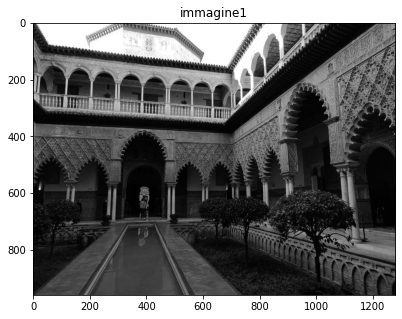

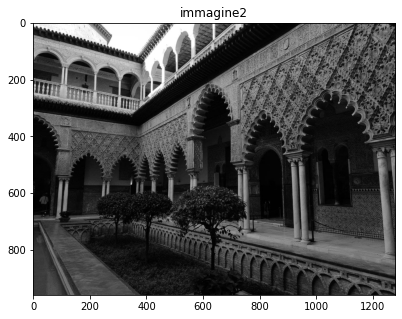

In [ ]:
al1= cv.imread('images/alcazar1.jpg',0)
al2=cv.imread('images/alcazar2.jpg',0)

plt.subplot(121)
plt.imshow(al1, cmap='gray')
plt.title('immagine1')
plt.show()

plt.subplot(122)
plt.imshow(al2, cmap='gray')
plt.title('immagine2')
plt.show()



In [ ]:
print("Dimensione immagine 1:", al1.shape)
print("Dimensione immagine 2:", al2.shape)

Dimensione immagine 1: (960, 1280)
Dimensione immagine 2: (960, 1280)


## Etrazione keypoint e descrittori

Viene inizializzata l'algoritmo SIFT_create(), la quale consentirà di individuare i keypoints, ovvero punti fortemente descrittivi dell'immagine ed i relativi descrittori delle immagini.

In [ ]:
sift = cv.xfeatures2d.SIFT_create()
kps1, features1	=	sift.detectAndCompute(al1, None)
kps2, features2= sift.detectAndCompute(al2, None)
print('Keypoint in immagine1:', len(kps1))
print('Keypoint in immagine2:', len(kps2))

Keypoint in immagine1: 8582
Keypoint in immagine2: 10091


Visualizzo ora i keypoints individuati

In [ ]:
#Visualizzazione punti SIFT
al_kps_1	=	cv.drawKeypoints(	al1, kps1, None, flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
al_kps_2	=	cv.drawKeypoints(	al2, kps2, None, flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


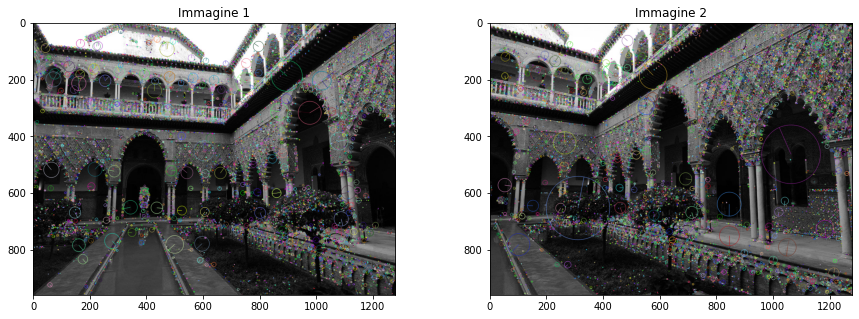

In [ ]:
plt.subplot(121)
plt.imshow(al_kps_1, cmap='gray')
plt.title('Immagine 1')

plt.subplot(122)
plt.imshow(al_kps_2, cmap='gray')
plt.title('Immagine 2')
plt.show()

## Matching
Ottenuti i descrittori ed i keypoint per entrambe le immagini, è possibile andare a cercare le corrispondenza tra di esse. Quindi, per unire le due immagini, è necessario trovare i punti di overlapping. \
Per farlo verrà utilizzata l'algoritmo BFMatcher() con crossCheck=True.  Il crossCheck, permette di restituire solo i valori accoppiati (i,j) tali che l'i-esimo descrittore dell'immagine1 abbia il j-esimo descrittore dell'immagine2 come miglior matching, e viceversa. Questo processo permette di avere un risultato consistente.

In [ ]:
bf = cv.BFMatcher(crossCheck= True) 
matches = bf.match(features1, features2)

Visualizzo ora i match individuati (solamente i migliori 20)

---



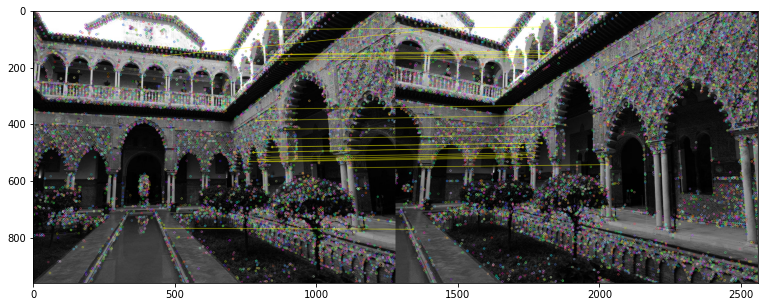

In [ ]:
matches = sorted(matches, key=lambda x:x.distance)
result = cv.drawMatches(al1, kps1, al2, kps2, matches[0:20], None, matchColor= [255,255,0])
plt.imshow(result, cmap='gray')

## Homography
Una volta trovati i migliori punti di corrispondenza tra le immagini, viene calcolata la loro homography matrix. 
La matrice omografica  , è una matrice di dimensione x , che determina una trasformazione in grado di mappare i punti dell'immagine sorgente sull'immagine di destinazione attraverso l'equazione **x'=Hx**. \
Per far ciò, è stata definita una funzione che, presi in input i punti chiave delle due immagini e i punti di intersezione, fosse in grado di calcolare l'omografia delle immagini. 

In [ ]:
def myHomography(kps1, kps2, matches):

  # Two Images' Key Points Coordinates Exctraction
  m = len(matches)
  pts1 = np.zeros((m, 1, 2), dtype=np.float32)
  pts2 = np.zeros((m, 1, 2), dtype=np.float32)
  
  for i in range(0,len(matches)):
    pts1[i] = kps1[matches[i].queryIdx].pt
    pts2[i] = kps2[matches[i].trainIdx].pt
    
  # Homography Development
  H, mask = cv.findHomography(pts2, pts1, cv.RANSAC, ransacReprojThreshold=2.0)

  return H

In [ ]:
homography1 = myHomography(kps1, kps2, matches)

In [ ]:
# Homography Matrix Visualization
homography1

array([[ 5.62964134e-01,  2.03971869e-02,  3.87889102e+02],
       [-2.02948150e-01,  8.14415971e-01,  1.16555178e+02],
       [-3.36008951e-04, -2.58491742e-05,  1.00000000e+00]])

Per poter applicare l'omografia generata al punto precedente, ho definito la funzione **myWarp(im, H)** che, data la matrice H e l'immagine im come input, calcola la trasformazione di quest'ultima.

In [ ]:
def myWarp(im, H):

  y = im.shape[0]
  x = im.shape[1]

  # ['br', 'tr', 'bl']
  pts = [(x,y), (x,0), (0,y)]
  pts_transf = []
  for p in pts:
    x_ = p[0]
    y_ = p[1]
    num_w = H[0,0]*x_ + H[0,1]*y_ + H[0,2]
    num_h = H[1,0]*x_ + H[1,1]*y_ + H[1,2]
    den = H[2,0]*x_ + H[2,1]*y_ + H[2,2]
    x1_ = int(num_w / den)
    y1_ = int(num_h / den)
    pts_transf.append((x1_, y1_))

  # Definition of New Image's Width and Height
  # w = min(br, tr)
  # h = min(y, bl, br)
  w = min(pts_transf[0][0], pts_transf[1][0])
  if ( (y > pts_transf[2][1] and y < pts_transf[0][1]) or
      (y < pts_transf[2][1] and y < pts_transf[0][1]) ):
    h = y
  elif y < pts_transf[2][1] and y > pts_transf[0][1]:
    h = min(y, pts_transf[0][1])
  else:
    h = min(pts_transf[2][1], pts_transf[0][1])

  # Generation New Image
  im_out = cv.warpPerspective(im, H, (w, h))

  return im_out

In [ ]:
im_warped = myWarp(al2, homography1)

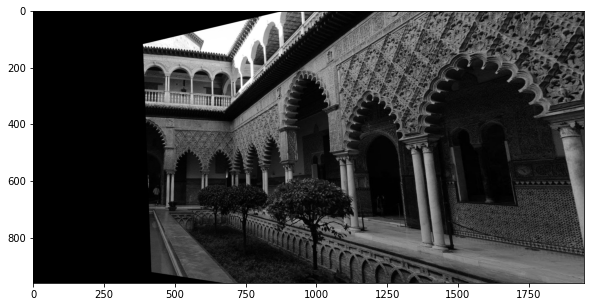

In [ ]:
plt.imshow(im_warped, cmap='gray')

## Integration
Come ultima fase è stata implementata la funzione **myCollage(im1, im2)** che, prendendo in input l'immagine originale di sinistra (im1) e quella di destra (im2), genera l'unione delle due immagini in input .

In [ ]:
def myCollage(im1, im2):

  # SIFT Instantiation
  sift = cv.xfeatures2d.SIFT_create()

  # Image 1's Key Points and Descriptors Search
  kps1, features1 = sift.detectAndCompute(im1, None)
  # Image 2's Key Points and Descriptors Search
  kps2, features2 = sift.detectAndCompute(im2, None)

  # Brute Force Matching
  bf = cv.BFMatcher(crossCheck = True)
  matches = bf.match(features1, features2)

  # Correspondences Sorting by Distance
  matches = sorted(matches, key=lambda x: x.distance)

  # Homography Matrix Generation
  H = myHomography(kps1, kps2, matches)

  # Perspective Transformation of Image 2
  im_warped = myWarp(im2, H)

  # Image Stitching Images 1 - 2
  im_warped[0:im1.shape[0], 0:im1.shape[1]] = im1

  return im_warped

In [ ]:
# Union Image Generation
imgs_stitched = myCollage(al1, al2)

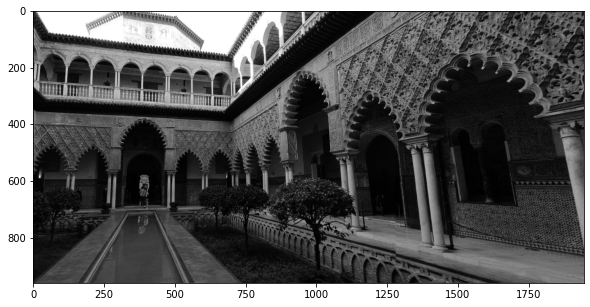

In [ ]:
plt.imshow(imgs_stitched, cmap='gray')

# Conclusioni


Come è possibile osservare, il risultato ottenuto è abbastanza soddisfacente. Di fatti l'immagine trasformata sembra essere stata proiettata correttamente ed inoltre rimane quasi impercettibile la divisione tra le due immagini. 